# 2D, viscoplastic relict lake (Figures 2 and 3)

## Problem description

This notebook produces Figure 3 in Bezu et al. (2025), which is inspired by Figure 2 in [MacAyeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3). The problem setup describes the formation of a pedestal due to differential ablation, and the formation of moat-rampart structures due to flexural resistance. In this viscoplastic treatment, the moat and rampart also produce rings of plastic damage. 

## Initial geometrical setup

First choose some basic initial parameters - domain size, ice temperature, timestep, etc.

In [1]:
Lx, Ly = 8000, 6000 #length and width of domain (m)
nx, ny = 300, 225 #grid resolution (m)
T = 273.15 - 5 #temperature (K)
κ_c = 1e-5 #critical curvature rate threshold for plasticity (m^-1 yr^-1)
H_gl = 200 #grounding line thickness (m)
u_gl = 20 #grounding line x-velocity (m/yr)
Δt = 1/50 #timestep (years)
num_years = 10 #choose how many years to model

r_1 = 1500  # radius of the low-albedo zone (m)
rate = -1 #melt rate over the rest of the domain (m/yr)

transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/relict_lake/' #where figures will be saved

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
norm = colors.TwoSlopeNorm(vcenter = 0)
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is included as another accompanying notebook
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater (kg/m^3)
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
year = icepack.constants.year #number of seconds in a year
A = icepack.rate_factor(Constant(T)) #flow constant

## Meshing 

In [4]:
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}_{u_gl}') #rectangle mesh
num_timesteps = int(num_years/Δt) + 1 #number of timesteps
deg = 1

Q = FunctionSpace(mesh, 'CG', deg) #function space for scalars (e.g., η)
S = TensorFunctionSpace(mesh, 'CG', deg) #function space for tensors (e.g, κ)
QS = Q*S #mixed function space for (η, κ)

q = Function(QS)
η_dot, κ_dot = split(q) #trial functions for the deflection rate and curvature rate
n_dot, k_dot = TestFunctions(QS) #test functions for those quantities
Δη = Function(Q) #function for each step's deflection update...
κ = Function(S) #...net curvature...
η = Function(Q) #...net deflection...
κ_p = Function(S) #...net plastic curvature...
γ = Function(Q) #...and unitless damage parameter

V = VectorFunctionSpace(mesh, 'CG', deg) #function space for vectors (e.g., u)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
p_y = Ly/2 #centerline
X = np.arange(0, Lx, 1) 
X = np.array([(k, p_y) for k in X]) #for plotting longitudinal profiles

## Initialize SSA solver

We need to modify icepack's ```gravity``` and ```terminus``` functions to allow for surface elevations which do not perfectly align with buoyant equilibrium (since eventually vertical deflections will invalidate this). 

In [5]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put these values into icepack's preferred units
G = g*year**2

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
H = H_0.copy(deepcopy = True)
s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

u_x = u_gl
u_y = A*(1/6*ρ_I*G*s)**3*(y - Ly/2) #since τ_yy = 1/6*ρ_i*g*s (analytic solution) and u_y(Ly/2) = 0 by symmetry
u = Function(V).project(as_vector((u_x, u_y)))

################################
################################
### modify icepack functions ###
################################
################################

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    flow_n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = Function(Q).project(icepack.models.viscosity._effective_strain_rate(ε, ε_min))
    ν = 1/2*A**(-1/flow_n)*ε_e**(1/flow_n - 1) #effective viscosity in MPa*yrs
    return Function(Q).project(ν*1e6) #return ν in units of Pa*yrs

###############################
###############################
### SSA boundary conditions ###
###############################
###############################

term_ids = [2, 3, 4] #in a biaxial spreading regime, both sides and the front are ice cliffs
inflow_ids = [1] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
sidewall_ids = []

opts = {
    'dirichlet_ids': inflow_ids,
    'side_wall_ids': sidewall_ids,
    'ice_front_ids': term_ids,
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Use icepack to spin up to steady state

In [6]:
residence_time = int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
dt = 2 #set the spinup timestep

for step in tqdm.trange(int(residence_time/dt)):
    
    u = flow_solver.diagnostic_solve(velocity = u,
                                     thickness = H, surface = s, fluidity = Constant(A))
    H = flow_solver.prognostic_solve(dt, thickness = H, velocity = u,
                                     thickness_inflow = H_0, accumulation = Constant(0))
    s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

s_0 = Function(Q, name = f'surface_{nx}_{T}_{u_gl}').project(s) 
H_0 = Function(Q, name = f'thickness_{nx}_{T}_{u_gl}').project(H)
b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation
b = b_0.copy(deepcopy = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [05:56<00:00,  1.78s/it]


## Determine ablation field and plot initial geometry

The pedestal will begin as a circle of radius ```r_1``` at the center of the domain. Outside the circle, the ablation rate is ```rate``` meters per year, but this will quickly approach zero within ```r_1``` of the circle's center. Specifically, this spatially variable ablation rate will occur as a 2D double-sigmoid curve:  

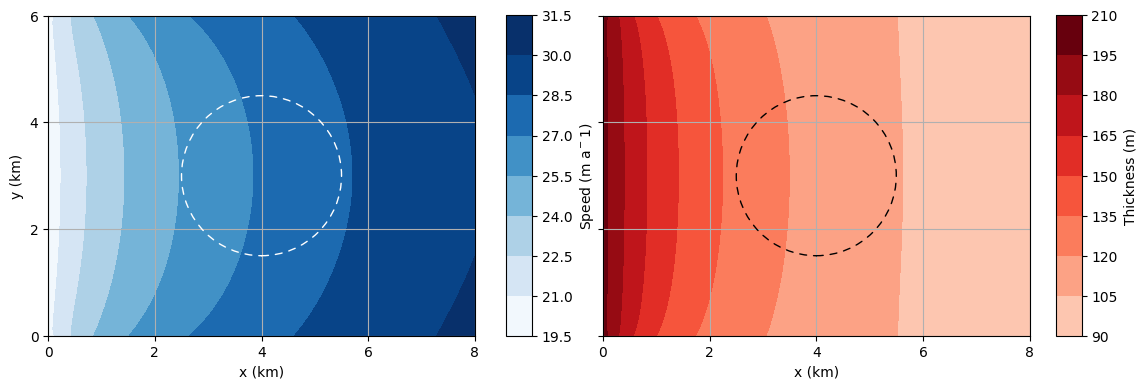

In [7]:
##################################
##################################
### describe the ablation rate ###
##################################
##################################

k = 0.04 # Steepness of the transition zone
p_x = Lx/2 #x-coord at the center of the circle
R = sqrt((x - p_x)**2 + (y - p_y)**2) #R := distance from (px, py)
d = Function(Q).project(1 - 1 / (1 + exp(k * (R - r_1)))) #the double-sigmoid
a_dot = Function(Q).project(rate*d) #and resulting ablation rate

##########################################
##########################################
### plot initial steady-state geometry ###
##########################################
##########################################

# Create side-by-side subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.6), sharey=True)  # Increased width to prevent overlap

# === PLOT 1: Initial Speed (Blues) ===
plot1 = tricontourf(Function(Q).project(sqrt(u[0]**2 + u[1]**2)), 
                     axes=ax1, cmap='Blues', vmin=20, vmax=30)  # Set colorbar range
ax1.set_aspect('equal')
ax1.add_patch(patches.Circle((p_x, p_y), r_1, 
                             edgecolor='white', linewidth=1, 
                             fill=False, zorder=3, capstyle='round', linestyle=(0, (5, 5))))
ax1.set_xticks(range(0, Lx + 1, 2000))
ax1.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
ax1.set_yticks(range(0, Ly + 1, 2000))
ax1.set_yticklabels(range(0, int(Ly / 1000) + 1, 2))
# ax1.set_title('Initial Speed (m/yr)')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.grid()

# === PLOT 2: Initial Thickness (Reds) ===
plot2 = tricontourf(Function(Q).project(H), axes=ax2, cmap='Reds', vmin=70, vmax=200)  # Set colorbar range
ax2.set_aspect('equal')
ax2.add_patch(patches.Circle((p_x, p_y), r_1, 
                             edgecolor='k', linewidth=1, 
                             fill=False, zorder=3, capstyle='round', linestyle=(0, (5, 5))))

ax2.set_xticks(range(0, Lx + 1, 2000))
ax2.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
# ax2.set_title('Initial Thickness (m)')
ax2.set_xlabel('x (km)')
ax2.grid()

# === COLORBARS ===
# Adjusted to match **exact height** of the plots
pos1 = ax1.get_position()
pos2 = ax2.get_position()

cax1 = fig.add_axes([pos1.x1 + 0.00, pos1.y0 + 0.02, 0.02, pos1.height - 0.04])  # Now exactly as tall as plot 1
cax2 = fig.add_axes([pos2.x1 + 0.00, pos2.y0 + 0.02, 0.02, pos2.height - 0.04])  # Now exactly as tall as plot 2

cbar1 = fig.colorbar(plot1, cax=cax1)
cbar2 = fig.colorbar(plot2, cax=cax2)

cbar1.ax.set_ylabel(f'Speed (m a$^{-1}$)')
cbar2.ax.set_ylabel('Thickness (m)')

# Adjust layout with **precise horizontal spacing**
plt.subplots_adjust(wspace=0.3, right=0.88)  # Slightly increased `wspace` for balance

plt.show()

## Initialize transport solver and specify the flexure boundary conditions

The flexure boundary conditions for this problem are (1) $\dot{\boldsymbol{\kappa}} = 0$ on each boundary (i.e., there is no curvature and therefore no bending stress exerted at the boundaries), and (2) $\dot{\eta} = -\frac{1}{\Delta t}h_{ab}$ on each boundary (i.e., the surface is lifted upward at exactly the rate required to maintain buoyant equilibrium, consistent with no bending stress). However, because $h_{ab}$ will generally change with each iteration, the $\dot{\eta}$ boundary condition is defined iteratively in the next cell. 

In [8]:
transport_model = TransportEquation(field_name = 'field', conservative = False) #for advection
transport_solver = TransportSolver(transport_model, **opts) #e.g., η, or the ablation field

###################################
###################################
### flexure boundary conditions ###
###################################
###################################

κ_bc = DirichletBC(QS.sub(1), 0*Identity(2), (1, 2, 3, 4)) #no curvature on any boundary 
#η boundary condition is defined iteratively in the next cell


###########################
###########################
### and set figure path ###
###########################
###########################

path = figures_path + f'nx-{nx}_H-{H_gl}_u-{u_gl}_T-{T}_t-{num_years}_Δt-{Δt}_κ_c-{κ_c}' #set more specific path for saving figures

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

In [9]:
os.getcwd()

'/home/firedrake/H3F/figures/relict_lake/nx-300_H-200_u-20_T-268.15_t-10_Δt-0.02_κ_c-1e-05'

## Solve flow-flexure problem with firedrake

See the steps laid out in Appendix B.

100%|██████████████████████████████████████████████████████████████████████████████▊| 500/501 [3:01:18<00:24, 24.50s/it]

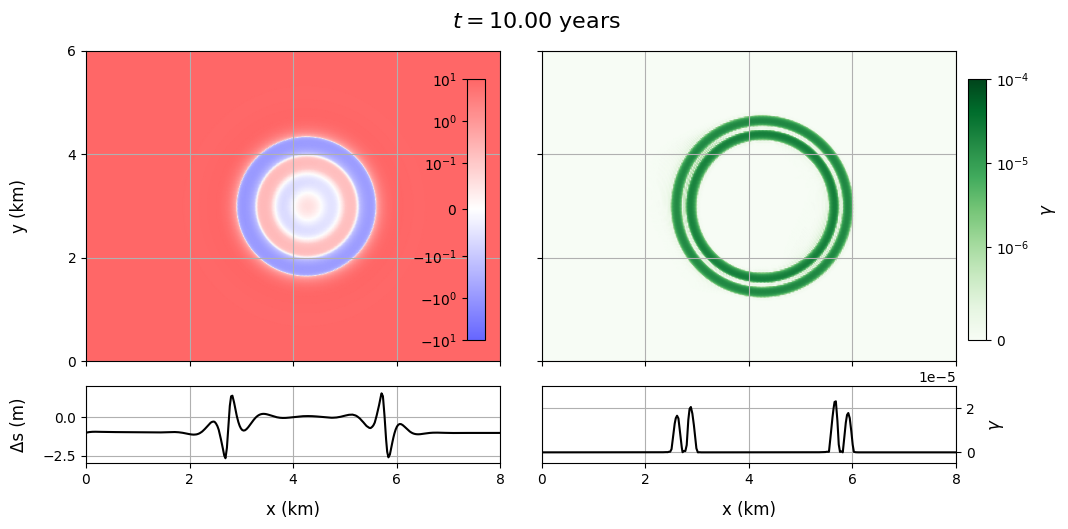

100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [3:01:49<00:00, 21.78s/it]


In [10]:
light_seismic = colors.LinearSegmentedColormap.from_list("light_seismic", ["#6666FF", "white", "#FF6666"], N=256) #define new colormap
plt.colormaps.register(name="light_seismic", cmap=light_seismic) #for better visibility of η's colorbar label and ticks

for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### (1) flow solution ###
    #########################
    #########################

    u = flow_solver.diagnostic_solve(velocity = u, fluidity = Constant(A),
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s, accumulation = Constant(0)) 

    ##########################################
    ##########################################
    ### (2) update flow-related parameters ###
    ##########################################
    ##########################################

    s.project(s + a_dot*Δt) #add in surface ablation
    H.project(s - b) #and note the resulting change to the thickness
        
    ε = Function(S).project(sym(grad(u))) #strain rate tensor from flow
    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor from flow
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor from flow
    
    h_ab = Function(Q).project(s - (1 - ϱ)*H) #difference between s and its equilibrium value
    
    ############################
    ############################
    ### (3) flexure solution ###
    ############################
    ############################

    q = Function(QS)
    η_dot, κ_dot = split(q)
    
    J_II = sqrt(1/2*(κ_dot[0, 0]**2 + κ_dot[1, 1]**2 + κ_dot[0, 1]**2 + κ_dot[1, 0]**2)) #J_II of κ_dot
    β = 1/2 #as described in Appendix B
    α = conditional(J_II > κ_c, (κ_c + β*(J_II - κ_c))/J_II, 1) #Appendix B

    C = Function(Q).project(1/6*ν*H**3)
    a = dot(div(C*κ_dot + C*tr(κ_dot)*Identity(2)), grad(n_dot))*dx - n_dot*ρ_w*g*η_dot*Δt*dx - dot(grad(η_dot*Δt), div(n_dot*H*σ))*dx   
    a += α*inner(ν*κ_dot, k_dot)*dx + dot(grad(η_dot), div(ν*k_dot))*dx
    L = n_dot*ρ_w*g*(h_ab)*dx + dot(grad(η), div(n_dot*H*σ))*dx #the weak form given in Appendix B 

    η_bc = DirichletBC(QS.sub(0), Function(Q).project(-h_ab/Δt), (1, 2, 3, 4)) #deflection rate at the boundary should restore equilibrium
    solve(a - L == 0, q, bcs = [κ_bc, η_bc])

    ########################################################
    ########################################################
    ### (4) update and advect flexure-related parameters ###
    ########################################################
    ########################################################

    Δη.project(η_dot*Δt) #update the change in deflection...
    η.project(η + Δη) #...the resulting net deflection...
    Δκ = κ_dot*Δt #...the change in curvature...
    κ.project(κ + Δκ) #...the resulting net curvature...
    κ_p.project(κ_p + (α - 1)*Δκ) #...and the resulting net plastic curvature
    
    s.project(s + Δη) #update the surface elevation
    b.project(b + Δη) #and the basal elevation
    Δs = Function(Q).project(s - s_0) #and also record the change in surface elevation for a more intuitive parameter to plot

    #also define each component of the curvature tensors explicitly for advection
    κ_xx, κ_xy, κ_yy = Function(Q).project(κ[0, 0]), Function(Q).project(1/2*(κ[0, 1] + κ[1, 0])), Function(Q).project(κ[1, 1])
    κp_xx, κp_xy, κp_yy = Function(Q).project(κ_p[0, 0]), Function(Q).project(1/2*(κ_p[0, 1] + κ_p[1, 0])), Function(Q).project(κ_p[1, 1])

    η = transport_solver.prognostic_solve(Δt, field = η, velocity = u, field_inflow = η, field_accumulation = Constant(0)) #advect
    η = Function(Q).project(η)
    
    d = transport_solver.prognostic_solve(Δt, field = d, velocity = u, field_inflow = d, field_accumulation = Constant(0))
    a_dot = Function(Q).project(rate*d)

    κ_xx = transport_solver.prognostic_solve(Δt, field = κ_xx, velocity = u, field_inflow = κ_xx, field_accumulation = Constant(0))
    κ_xy = transport_solver.prognostic_solve(Δt, field = κ_xy, velocity = u, field_inflow = κ_xy, field_accumulation = Constant(0))
    κ_yy = transport_solver.prognostic_solve(Δt, field = κ_yy, velocity = u, field_inflow = κ_yy, field_accumulation = Constant(0))
    κp_xx = transport_solver.prognostic_solve(Δt, field = κp_xx, velocity = u, field_inflow = κp_xx, field_accumulation = Constant(0))
    κp_xy = transport_solver.prognostic_solve(Δt, field = κp_xy, velocity = u, field_inflow = κp_xy, field_accumulation = Constant(0))
    κp_yy = transport_solver.prognostic_solve(Δt, field = κp_yy, velocity = u, field_inflow = κp_yy, field_accumulation = Constant(0))

    κ.project(as_tensor([[κ_xx, κ_xy], [κ_xy, κ_yy]]))
    κ_p.project(as_tensor([[κp_xx, κp_xy], [κp_xy, κp_yy]]))
    γ.project(sqrt(1/2*(κ_p[0, 0]**2 + κ_p[1, 1]**2 + κ_p[0, 1]**2 + κ_p[1, 0]**2))) #damage as J_II(κ_p)
    
    ########################
    ########################
    ### (5) plot results ###
    ########################
    ########################
    
    if step % 10 == 0: #no need to plot for every single step
        
        # Customization Variables
        fontsize = 12
        fontsize_ticks = 10
    
        # Dynamic height ratio while keeping total height fixed
        height_ratio_top = 3 * (Ly / 4000)
        height_ratio_bottom = 1
    
        # Set figure and axes (fixed figure size)
        fig, axs = plt.subplots(2, 2, figsize=(12, 5.6),
                                gridspec_kw={'height_ratios': [height_ratio_top, height_ratio_bottom]},
                                sharex='col')
    
        # Assign axes
        (ax1, ax2), (ax3, ax4) = axs
    
        # Function to configure tripcolor plots
        def setup_tripcolor(ax, data, cmap, norm=None):
            plot = tripcolor(data, axes=ax, cmap=cmap, norm=norm)
            ax.set_xlim(0, Lx)
            ax.set_ylim(0, Ly)
            ax.set_aspect(1)
            ax.grid(True)
            # ax.add_patch(patches.Circle((p_x, p_y), r_1, color='black', linestyle='dashed', linewidth=1, fill=False, zorder=3))
            return plot
    
        def add_colorbar(ax, plot, label, position, ticks=None):
            pos = ax.get_position()
            if position == "inside_right":
                cax = fig.add_axes([pos.x1 - 0.035, pos.y0 + 0.02, 0.015, pos.height - 0.1])  # Inside η plot (Right)
            else:
                cax = fig.add_axes([pos.x1 - 0.04, pos.y0 + 0.02, 0.015, pos.height - 0.1])  # Outside γ plot (Right)
            cbar = fig.colorbar(plot, cax=cax, orientation='vertical')
    
            if position == "inside_right":  # This applies only to η
                text_color = "black"
                cbar.ax.yaxis.set_label_position("left")
                cbar.ax.yaxis.set_ticks_position("left")
            else:  # γ colorbar remains black
                text_color = "black"
                cbar.ax.yaxis.set_label_position("right")
                cbar.ax.yaxis.set_ticks_position("right")
    
            # **Apply the text color**
            cbar.ax.yaxis.label.set_color(text_color)  # Set colorbar label color
            cbar.ax.tick_params(labelsize=fontsize_ticks, colors=text_color)  # Set tick label color
    
            cbar.set_label(label, fontsize=fontsize, labelpad=8)
    
            # **Ensure η ticks are integers**
            if ticks:
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([str(int(t)) for t in ticks])
    
        # === TOP PLOTS (Tripcolor) ===
        plot1 = setup_tripcolor(ax1, η, cmap='light_seismic', norm=colors.SymLogNorm(linthresh=1/10, linscale=1, 
                                               vmin=-10, vmax=10, base=10))
        plot2 = setup_tripcolor(ax2, γ, cmap='Greens', norm=colors.SymLogNorm(linthresh=1e-6, linscale=1, vmin=0, vmax=1e-4, base=10))
    
        # **Add Colorbars**
        add_colorbar(ax2, plot2, r'$\gamma$', position="outside_right")  # γ Outside (No Change)
    
        if num_timesteps - step > 1: 
            add_colorbar(ax1, plot1, r'$\eta$ (m)', position="inside_right")  # η Inside, Dynamic Label Color
        else: 
            add_colorbar(ax1, plot1, '', position="inside_right")  # η Inside, Dynamic Label Color
    
        # Remove tick labels for the top-right plot
        ax2.set_xticklabels([])
    
        # Configure y-axis for both top plots (tick marks every 2 km)
        y_ticks = np.arange(0, Ly + 1, 2000)  # Step by 2000 meters (every 2 km)
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels([str(int(t / 1000)) for t in y_ticks], fontsize=fontsize_ticks)
        ax1.set_ylabel('y (km)', fontsize=fontsize, labelpad=10)
    
        ax2.set_yticks(y_ticks)
        ax2.set_yticklabels([])  # No tick labels for the right plot
    
        # === BOTTOM PLOTS ===
        ax3.plot(Δs.at(X, tolerance=1e-10), 'k')  # **Δs in black, linewidth 1, NO label**
        ax4.plot(γ.at(X, tolerance=1e-10), 'k')
    
        # Configure bottom plots
        for ax, label in zip([ax3, ax4], ['Δs (m)', r'$\gamma$']):
            ax.set_xlim(0, Lx)
            ax.set_xlabel('x (km)', fontsize=fontsize, labelpad=10)
            ax.set_xticks(range(0, Lx + 1, 2000))  # Tick marks every 2 km
            ax.set_xticklabels(range(0, int(Lx / 1000) + 1, 2), fontsize=fontsize_ticks)
            ax.grid(True)
            ax.set_ylabel(label, fontsize=fontsize, labelpad=10)
    
        # Adjust bottom-right y-axis to appear on the right
        ax4.yaxis.set_label_position("right")
        ax4.yaxis.tick_right()
    
        # ax3.set_ylim(-3, 2)  # Δs from -3 to +2
        # ax4.set_ylim(-0.5e-5, 3e-5)  # γ from 0 to 3e-5
    
    
        # **Align labels properly**
        for ax in [ax1, ax3]:
            ax.yaxis.set_label_coords(-0.14, 0.5)
    
        # Keep figure size unchanged, adjust spacing only
        plt.subplots_adjust(right=0.85, hspace=0.02 * (Ly / 4000), wspace=0.1)
        fig.suptitle(f'$t = {step*Δt:.2f}$ years', fontsize=16, y=0.92)
    
        plt.savefig(f'{step}')
    
        if num_timesteps - step > 1:
            plt.close()
        else:
            plt.show() #only show the last plot